In [26]:
filename = "s_unit_attack_output_2025-04-10_13.14.12.csv"

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import json, pyperclip
import csv
from collections import defaultdict

In [28]:
def load_csv(filename):
    grouped_data = defaultdict(lambda: {
        "n": None,
        "k": None,
        "runs": []
    })

    with open(filename, 'r', newline='') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            # Parse base parameters
            n = int(row["n"])
            k = float(row["k"])
            
            key = (n, k)

            grouped_data[key]["n"] = n
            grouped_data[key]["k"] = k

            # Clean and convert values
            try:
                run = {
                    "i": int(row["iteration"]),
                    "iterations": int(row["num_inner_iteration"]),
                    "alpha_in": str(row["alpha_in"]),
                    "alpha_in_norm": float(row["alpha_in_norm"]),
                    "alpha_out": str(row["alpha_out"]),
                    "alpha_out_norm": float(row["alpha_out_norm"]),
                    "alpha_in_norm": float(row["alpha_in_norm"]),
                    "alpha_out_norm": float(row["alpha_out_norm"]),
                    "time": float(row["time"]),
                }
            except Exception as e:
                print(f"Error parsing row: {row}\n{e}")
                continue

            grouped_data[key]["runs"].append(run)

    return list(grouped_data.values())


In [29]:
data = load_csv(filename)

pyperclip.copy(json.dumps(data, indent=2))
print(f"{len(data)} blocks loaded from {filename} and copied to clipboard.")

206 blocks loaded from s_unit_attack_output_2025-04-10_13.14.12.csv and copied to clipboard.


In [45]:
def plot(key, key_title, log=False):
    
    map_n_map_k_vs_key_mean = {}
    map_n_map_k_vs_key_stderr = {}

    for block in data:
        n = block["n"]
        k = block["k"]

        if n not in map_n_map_k_vs_key_mean:
            map_n_map_k_vs_key_mean[n] = {}
            map_n_map_k_vs_key_stderr[n] = {}

        if len(block["runs"]) == 0:
            continue

        values = [run[key] for run in block["runs"]]
        if key == "alpha_out_norm":
            values = []
            for run in block["runs"]:
                if run["alpha_out"] == 0: run["alpha_out"] = 1
                v = run["alpha_in_norm"] / run["alpha_out_norm"]
                values.append(abs(v))
        avg_values = sum(values) / len(values)
        stderr = np.std(values, ddof=1) / np.sqrt(len(values))  # standard error

        map_n_map_k_vs_key_mean[n][k] = avg_values
        map_n_map_k_vs_key_stderr[n][k] = stderr
    
    num_plots = len(map_n_map_k_vs_key_mean)
    cols = min(6, num_plots)
    rows = (num_plots + cols - 1) // cols

    plt.figure(figsize=(5 * cols, 5 * rows))

    colours = list(colors.TABLEAU_COLORS.values())
    for i, (n, map_k_vs_iterations) in enumerate(map_n_map_k_vs_key_mean.items(), 1):
        plt.subplot(rows, cols, i)
        x = list(map_k_vs_iterations.keys())
        y = list(map_k_vs_iterations.values())
        yerr = [map_n_map_k_vs_key_stderr[n][val] for val in x]
        c = colours[(i-1) % len(colours)]

        plt.plot(x, y, 'o-', color=c, label=f'n={n}')
        plt.fill_between(x, np.array(y) - np.array(yerr), np.array(y) + np.array(yerr), alpha=0.2, label='Std Error', color=c)
        plt.xlabel('k')
        if log: plt.yscale('log', base=2)  
        plt.ylabel(f'Avg {key_title}')
        plt.title(f'n={n}')
        plt.grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

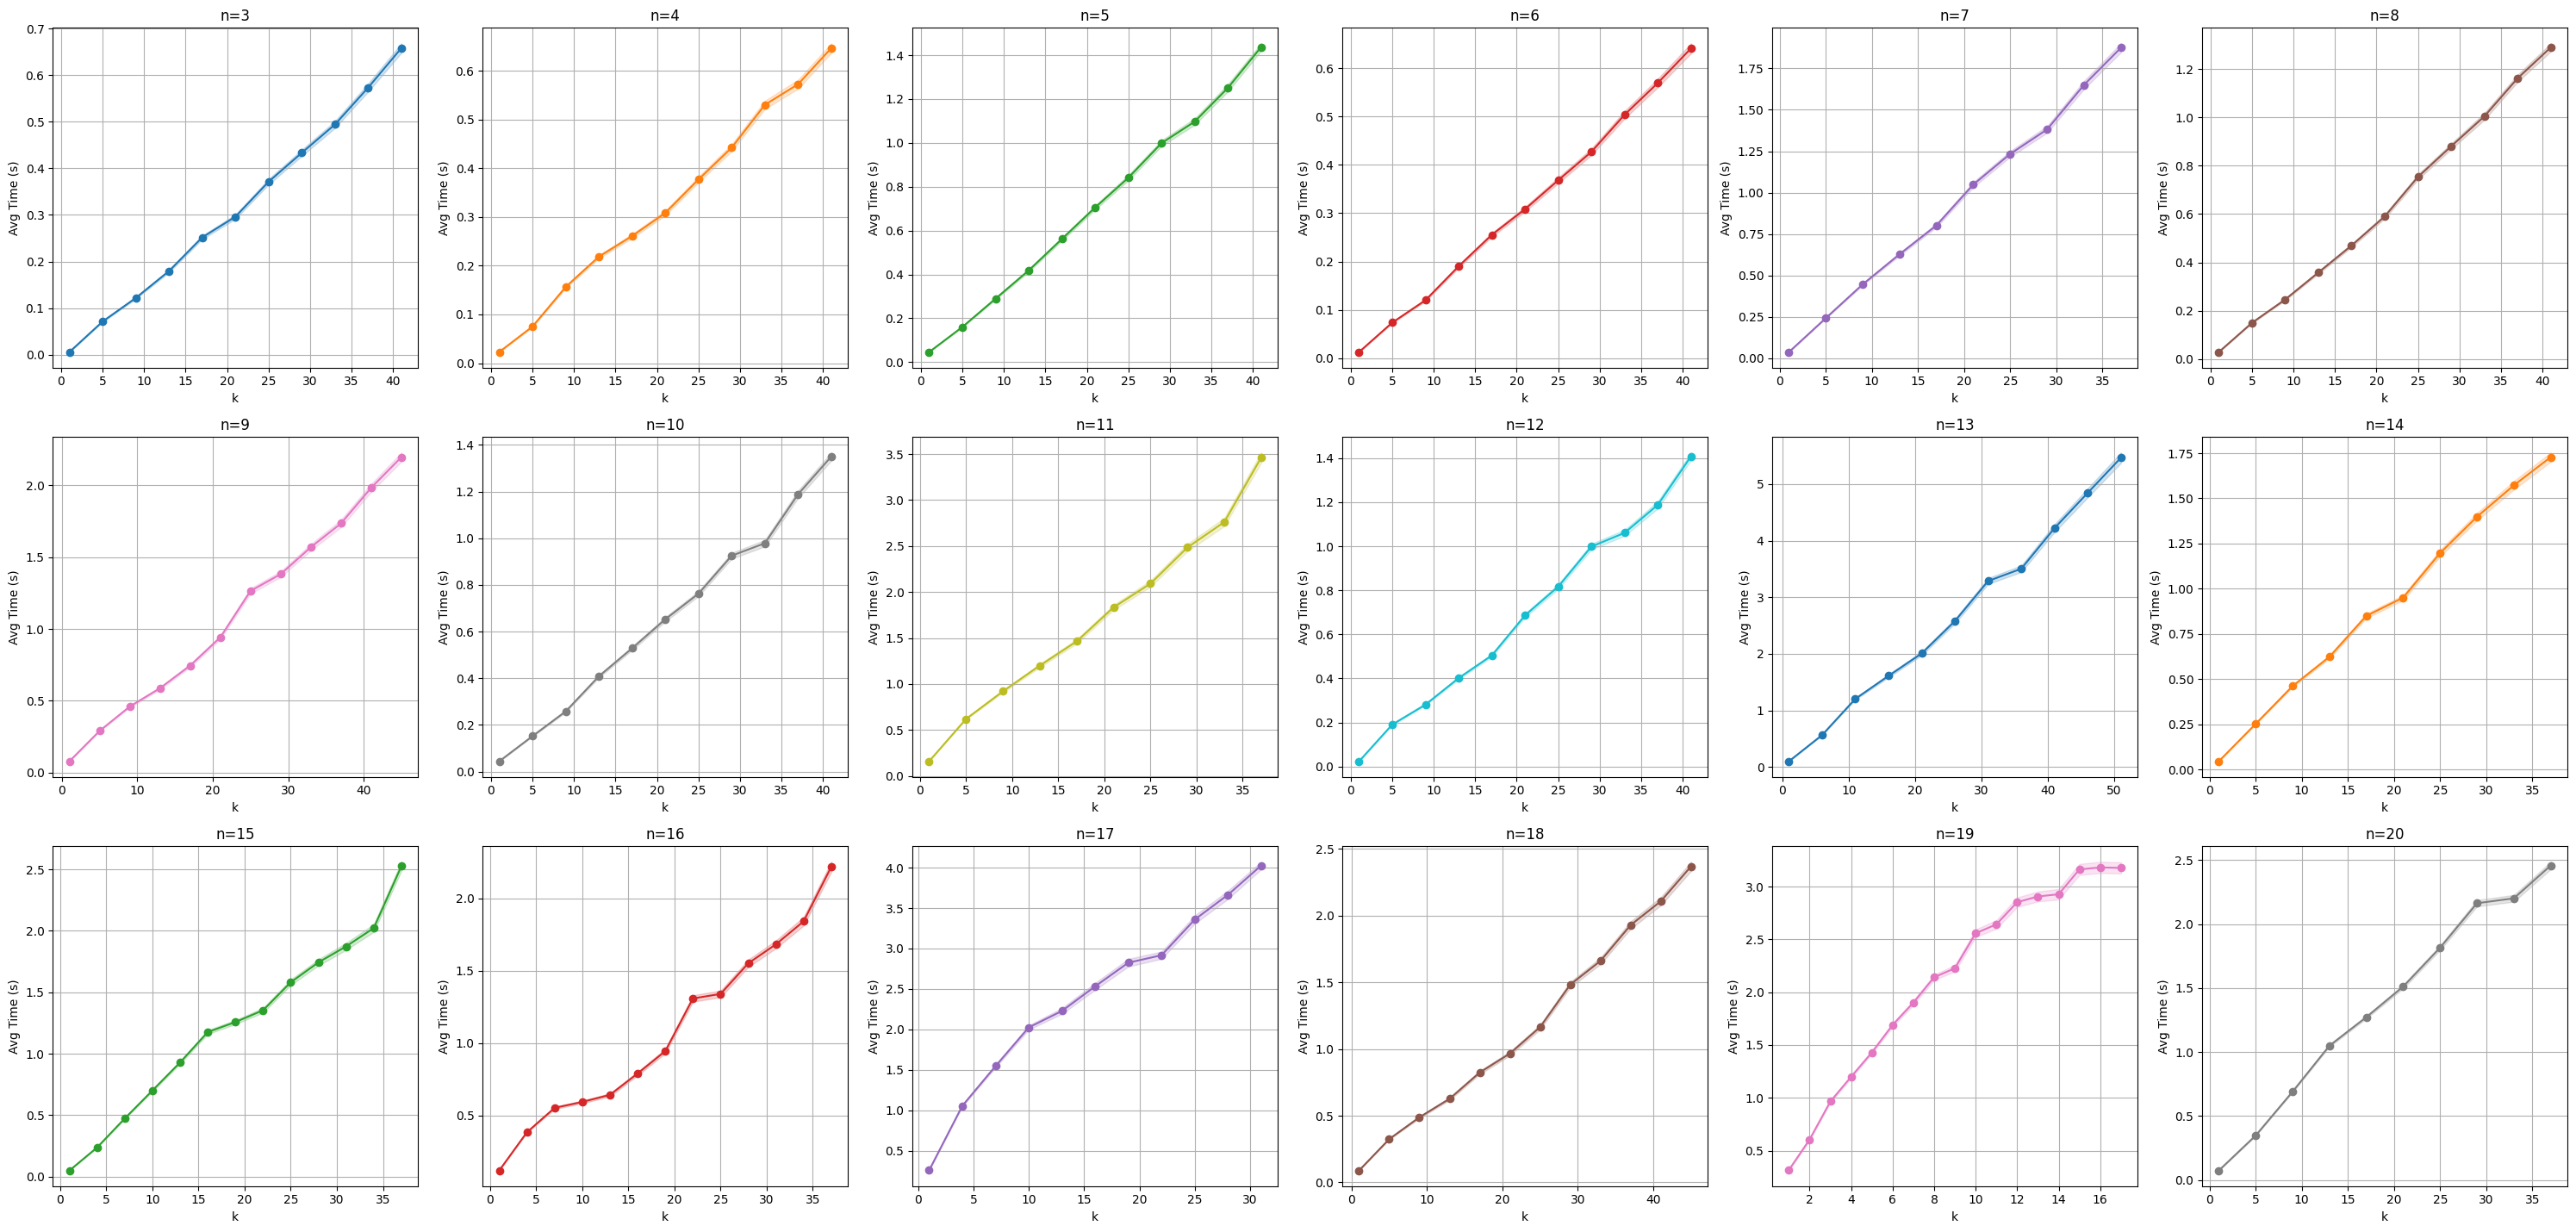

In [36]:
plot("time", "Time (s)")

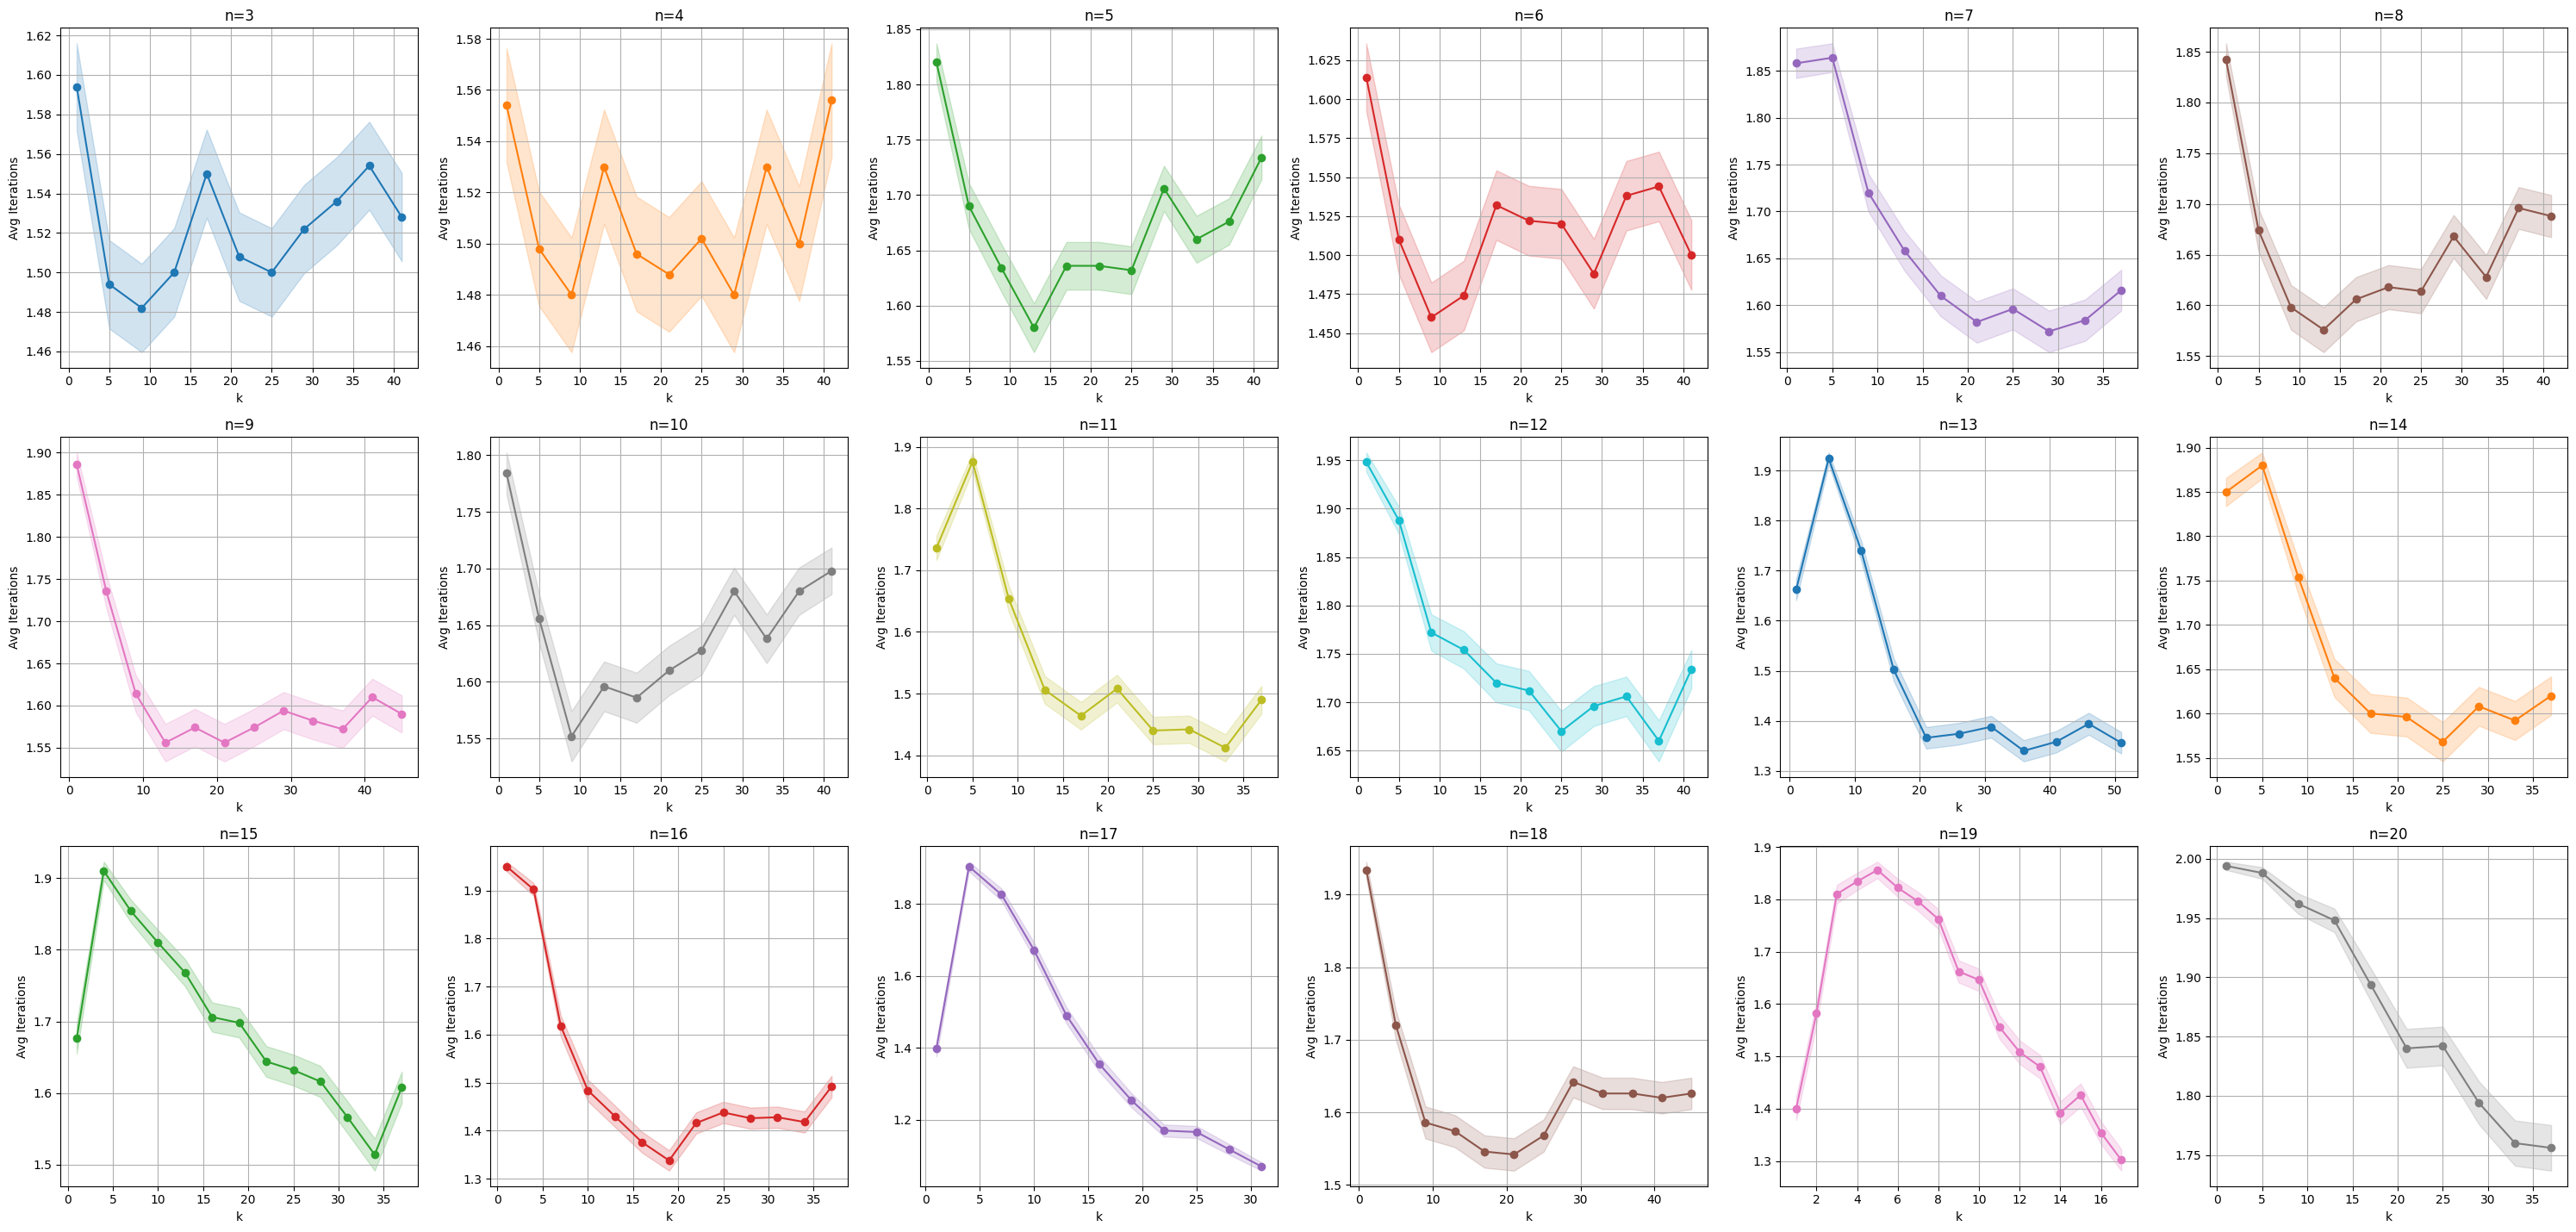

In [37]:
plot("iterations", "Iterations")

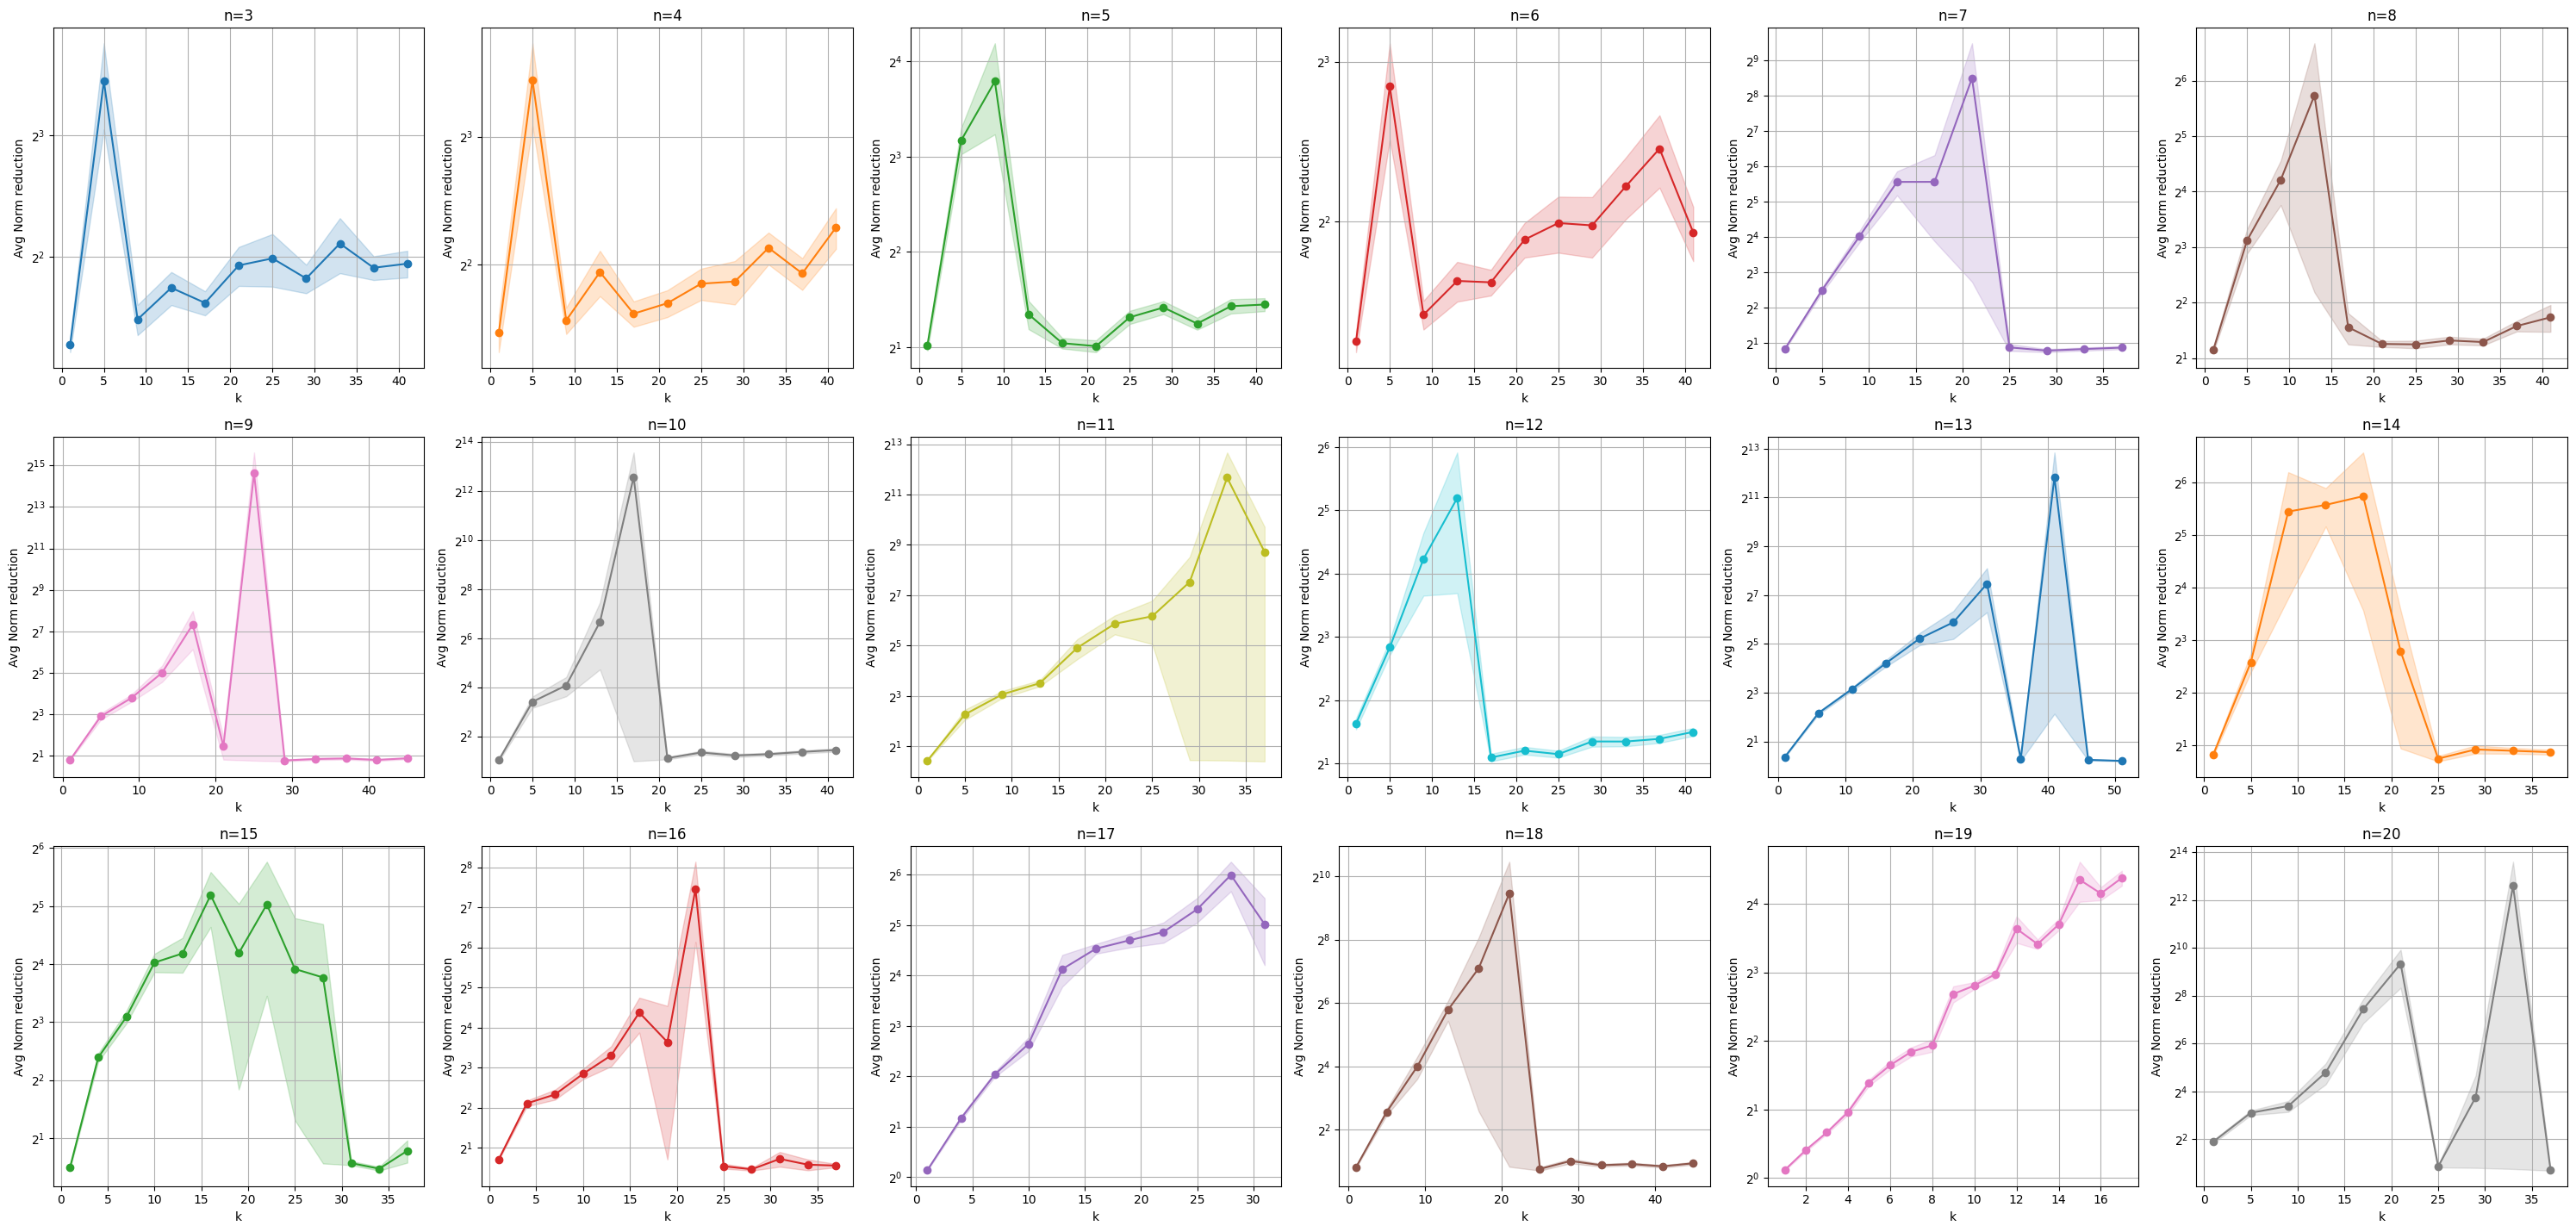

In [47]:
plot("alpha_out_norm", "Norm reduction", log=True)